# Empirical application I: estimating a trade network

We are taking the data set used in Bykhovskaya (2019) to model the network of trade in pharmaceuticals among the twelve original European Union member states. We will take first differences across time and estimate the network of average growth rates. Based on this noisy estimate, we find coefficient-wise confidence intervals for the estimated network centralities.

In [6]:
using TimeSeries, Distributions, Statistics, LinearAlgebra, CSV, DataFrames, Random, Colors
trade_flows_vectorised = DataFrame(CSV.File("data/30euro_clean.csv";header=false));

Convert this table to a sequence of adjacency matrices. To be able to abstract away from missing data issues, we start the sample in November 2004 until February 2018. This reduction provides us with a sample of length $T=161$ for a $7 \times 7$ network. We estimate the adjacency matrix $M$ by $\hat{M}$ as in Simons (2023). In particular, we average the first differences of the natural logarithm, which provides an estimate of the average growth rate. To account for potential serial correlation in the errors, we use a HAC estimator to estimate a robust covariance matrix. We interpret the nodes in the directed graph that have on average grown their trade balance the most and with most connections as the most central actors in the trade network and estimate eigenvector centralities and provide one-sided confidence intervals.

In [7]:
t_start = 70;
T = size(trade_flows_vectorised)[2]
trade_matrices = zeros(12,12,T-t_start+1);
trade_matrices_wm = zeros(Union{Missing,Float64},12,12,T-t_start+1);
trade_matrices_wm_fd = zeros(Union{Missing,Float64},12,12,T-t_start+1);

for t in t_start:T
    k=1;
    for i in 1:12
        indices = filter!(e->e≠i,collect(1:12))
        for j in indices
            #don't touch missing values
            trade_matrices_wm[i,j,t-t_start+1] = trade_flows_vectorised[k,t];
            
            if Missing == typeof(trade_flows_vectorised[k,t])
                #fill in zeros for missing values
                trade_matrices[i,j,t-t_start+1] = 0;
            else
                #non-missing observation
                trade_matrices[i,j,t-t_start+1] = trade_flows_vectorised[k,t];
            end            
            k += 1;
        end #j
    end #i
end #t

Construct a table of node labels.

In [8]:
using DataFrames
country_labels = DataFrame(NodeOld = 1:12,Country = ["FR","NL","DE","IT","UK","IE","DK","EL","PT","ES","BE","LU"])

Row,NodeOld,Country
,Int64,String
1,1,FR
2,2,NL
3,3,DE
4,4,IT
5,5,UK
6,6,IE
7,7,DK
8,8,EL
9,9,PT


Check which nodes have missing values as the first observation.

In [9]:
missingmatrix = zeros(12,12);

for i in 1:12, j in i+1:12
    missingmatrix[i,j] = length(findall(ismissing.(trade_matrices_wm[i,j,:])));
    missingmatrix[j,i] = length(findall(ismissing.(trade_matrices_wm[j,i,:])));
end

first_entry_missing = zeros(Bool,12,12)
pairs_w_first_entry_missing = []
pairs_w_first_entry_notmissing = []

for i in 1:12, j in i+1:12
    first_entry_missing[i,j] = 1 == findfirst(ismissing.(trade_matrices_wm[i,j,:]));
    first_entry_missing[j,i] = 1 == findfirst(ismissing.(trade_matrices_wm[j,i,:]));
    if 1 == findfirst(ismissing.(trade_matrices_wm[i,j,:]))
        push!(pairs_w_first_entry_missing,[i j]) else
        push!(pairs_w_first_entry_notmissing,[i j])
    end;
    if 1 == findfirst(ismissing.(trade_matrices_wm[j,i,:]))
        push!(pairs_w_first_entry_missing,[j i]) else
        push!(pairs_w_first_entry_notmissing,[j i])
    end;
end
l = length(pairs_w_first_entry_missing)
#recall that reshape goes through the dimensions in order so exhausts the first dimension then the second etc.
pairs_to_eliminate = reshape(stack(pairs_w_first_entry_missing),(2,l))'
pairs_to_keep = reshape(stack(pairs_w_first_entry_notmissing),(2,length(pairs_w_first_entry_notmissing)))'
for row in eachrow(pairs_to_eliminate)
    println("First observation for pair [",row[1],", ",row[2],"] is ",trade_matrices_wm[row[1],row[2],1])
end
nodes_to_eliminate = unique(pairs_to_eliminate);
println("Nodes to eliminate",nodes_to_eliminate)

First observation for pair [12, 6] is missing
First observation for pair [7, 12] is missing
First observation for pair [8, 10] is missing
Nodes to eliminate

[12, 7, 8, 6, 10]


Eliminate nodes that have a missing value as the first observation and check that taking logarithms and first differences does not produce `NaN` or `Inf` entries.

In [10]:
p=12-length(nodes_to_eliminate);
trade_matrices_cf = zeros(Float64,p,p,T-t_start+1) #carried forward for missing values

k=0;
locf(v) = v[accumulate(max,[i*!ismissing(v[i]) for i=1:length(v)])]
row_indices = filter!(e -> e ∉(nodes_to_eliminate),collect(1:12))
node_hash_map = zeros(length(row_indices),2)
for i in enumerate(row_indices)
    node_hash_map[i[1],1] = i[2]; #put the old node in
    node_hash_map[i[1],2] = i[1]; #put the new node in
    col_indices = filter!(e -> e ≠ i && e ∉(nodes_to_eliminate),collect(1:12))
    for j in enumerate(col_indices)
        trade_matrices_cf[i[1],j[1],:] = locf(trade_matrices_wm[i[2],j[2],:])
    end #j
end #i

#find first differences
trade_matrices_cf_fd = zeros(Float64,p,p,T-t_start+1-1)

function simple_check(x)
    any(isnan.(x)) || any(.!isfinite.(x))
end

for i in 1:p, j in i+1:p
    trade_matrices_cf_fd[i,j,:] = diff(log.(trade_matrices_cf[i,j,:]));
    trade_matrices_cf_fd[j,i,:] = diff(log.(trade_matrices_cf[j,i,:]));
    if simple_check(trade_matrices_cf_fd[i,j,:]) println("Nan or Inf at ",i," ",j) end
    if simple_check(trade_matrices_cf_fd[j,i,:]) println("Nan or Inf at ",j," ",i) end
end

node_conversion_table = DataFrame(  NodeOld = node_hash_map[:,1],
            NodeNew = node_hash_map[:,2]);


## Estimate centralities based on average growth rate

In [11]:
using CovarianceMatrices
include("eigenvector_estimates_cis.jl")
p = size(trade_matrices_cf_fd)[1];
T = size(trade_matrices_cf_fd)[3];
vectorised_matrices = reshape(trade_matrices_cf_fd,(p^2,T));
y = vectorised_matrices'
X   = ones(T,1)
_,K = size(X)
b   = X\y
res = y - X*b

kernel = QuadraticSpectralKernel{NeweyWest}()
bw = CovarianceMatrices.optimalbandwidth(kernel, res, prewhite=false);
Ψ   = lrvar(QuadraticSpectralKernel(bw), res, scale = T^2/(T-K))   # df adjustment is built into vcov
estimates_abs_tuple = eigenvector_estimates_cis_abs(trade_matrices_cf_fd ,1,0.05,false,Ψ);
estimates_abs = estimates_abs_tuple[1]
graph_estimate = estimates_abs_tuple[2];

Note that the array `estimates_abs` has the point estimates and upper bounds as the first two matrices and the value of the objective function for the finding of an upper bound as its third matrix. 

In [14]:
#make a table for the eigenvector centralities
eigenvector_centralities = DataFrame(   NodeOld = node_hash_map[:,1],
                                        NodeNew = node_hash_map[:,2],
                                        country = ["A","B","C","D","E","F","G"],
                                        LogCentrality = log.(estimates_abs[:,1,1]),
                                        LogCentrality_upper = log.(estimates_abs[:,1,2]),
                                        LogCentrality_error = log.(estimates_abs[:,1,2]) - log.(estimates_abs[:,1,1]));
eigenvector_centralities = leftjoin(eigenvector_centralities,country_labels,on = :NodeOld=>:NodeOld)
sort!(eigenvector_centralities,:LogCentrality,rev=true)
eigenvector_centralities[!,:Country] = convert.(String,eigenvector_centralities[!,:Country])
#CSV.write("network_statistics.csv",eigenvector_centralities)

7-element Vector{String}:
 "PT"
 "DE"
 "NL"
 "UK"
 "IT"
 "FR"
 "BE"

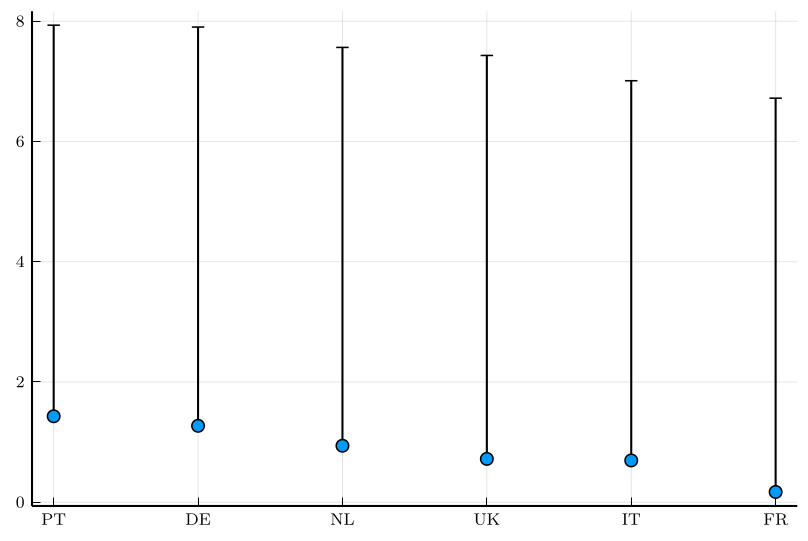

In [17]:
using Plots
pgfplotsx()
endrow = size(node_conversion_table)[1]-1
centralities_plot = plot(   eigenvector_centralities[1:endrow,:Country],
        eigenvector_centralities[1:endrow,:LogCentrality],
        yerr = (zeros(endrow),
                eigenvector_centralities[1:endrow,:LogCentrality_error]),
        linetype=:scatter,label="")
centralities_plot

In [18]:
savefig(centralities_plot,"plots/centrality_intervals.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/plots/centrality_intervals.svg"

Visualise the associated (average) graph of growth rates using a `SimpleWeightedDigraph` object.

In [19]:
#WARNING: both GraphMakie and GraphRecipes export "graphplot"; uses of it in module Main must be qualified
using CairoMakie, GraphMakie, Graphs, SimpleWeightedGraphs, GraphMakie.NetworkLayout
#use GLMakie for the interactive version
#using Karnak, Graphs, SimpleWeightedGraphs, NetworkLayout, Colors
g = SimpleWeightedDiGraph(p);
width_vec = 1 .+ zeros(2*p);
width_vec[1:7] =  ones(7);
k=1
for i in 1:p, j in i+1:p
    add_edge!(g,i,j,graph_estimate[i,j]);
    add_edge!(g,j,i,graph_estimate[j,i]);
    #width_vec[k] = graph_estimate[i,j];
    k += 1;
    #width_vec[k] = graph_estimate[j,i];
    k += 1;
    #println("i ",i," j ",j," ",graph_estimate[i,j])
end

Plot this again using only greyscale colours.

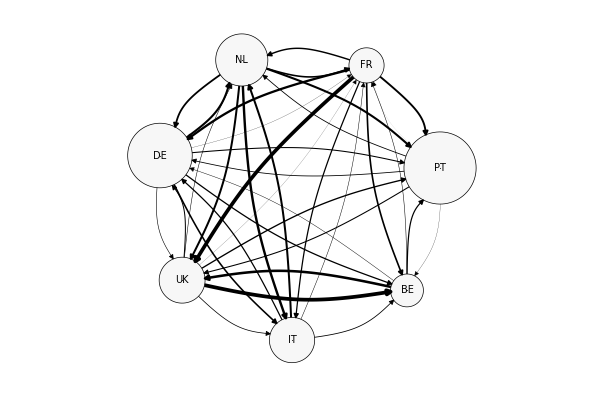

In [23]:
using GraphRecipes
pythonplot()
c = exp.(eigenvector_centralities[:,:LogCentrality]);

gpout_greyscale = GraphRecipes.graphplot(g,
                        node_weights = c,
                        names  = eigenvector_centralities[:,:Country],
                        nodeshape = :circle,
                        nodesize = .25,
                        nodecolor = "grey97",
                        markerstrokewidth=.5,
                        edgewidth = (s,d,w) -> 200*graph_estimate[s,d],
                        method=:sfdp)



In [24]:
savefig(gpout_greyscale,"plots/graph_w_centralities_trade_raw_simple.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/plots/graph_w_centralities_trade_raw_simple.svg"